In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

import os
os.environ['NUMEXPR_MAX_THREADS'] = '32'
%load_ext autoreload

In [2]:
import pickle
import sys

import numpy as np
import pandas as pd

module_path = os.path.abspath('/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/')
if module_path not in sys.path:
    sys.path.append(module_path)
from optimization.dictionary import LoadMZML

2023-11-29 10:28:04,694 - matplotlib - DEBUG - matplotlib data path: /home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/mpl-data
2023-11-29 10:28:04,700 - matplotlib - DEBUG - CONFIGDIR=/home/zixuanxiao/.config/matplotlib
2023-11-29 10:28:04,703 - matplotlib - DEBUG - interactive is False
2023-11-29 10:28:04,703 - matplotlib - DEBUG - platform is linux
2023-11-29 10:28:04,813 - matplotlib - DEBUG - CACHEDIR=/home/zixuanxiao/.cache/matplotlib
2023-11-29 10:28:04,815 - matplotlib.font_manager - DEBUG - Using fontManager instance from /home/zixuanxiao/.cache/matplotlib/fontlist-v330.json


In [16]:
# path to the data input in mzML format, containing only MS1 level data
msconvert_file = '/mnt/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/BBM_647_P241_02_07_ssDDA_MIA_001.mzML' 
# path to MaxQuant results (evidence.txt) of the same RAW file, used for constructing reference dictionary
#maxquant_txt =  '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/combined/txt/evidence_transfer_RT_pred_filtered.txt' 
# path to MaxQuant pickle file containing isotope pattern calculation
maxquant_dict_pickle = '/mnt/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/1FDR/combined/txt/evidence_1_FilteredByClosestRT_transfer_RT_pred_filtered_withIso.pkl'

In [4]:
dirname = os.path.dirname(msconvert_file)
basename = os.path.basename(msconvert_file)
filename = basename[:-5]+'_ScanByScan'
#filename += '_isospec'+str(isospec)+'_dev'+str(dev)+'_initWithCos'+str(initWithCos)+'_IDwithCos'+str(IDwithCos)
print('Filename:', filename)
if not os.path.exists(os.path.join(dirname, filename)):
    os.makedirs(os.path.join(dirname, filename))
filename_full = os.path.join(dirname, filename)
insilico_file = os.path.join(filename_full, filename +'_insilico.xlsx')
output_file = os.path.join(filename_full, filename + '_output') #filename


Filename: BBM_647_P241_02_07_ssDDA_MIA_001_ScanByScan


# Data Loading
## Load maxquant result 

In [17]:
# with isotope pattern
try:
    Maxquant_result_dict = pd.read_pickle(filepath_or_buffer=maxquant_dict_pickle)
    logging.debug('Loaded maxquant result with isotope pattern.')
except FileNotFoundError: # if not found, read txt and generate
    logging.info('Maxquant result with isotope pattern not found, calculating from evidence.txt!')
    Maxquant_result_dict = pd.read_csv(filepath_or_buffer=maxquant_txt, sep='\t')
    from optimization.dictionary import CalcModpeptIsopattern
    Maxquant_result_dict['IsoMZ'], Maxquant_result_dict['IsoAbundance'] = \
        zip(*Maxquant_result_dict.apply(lambda row: 
                                   CalcModpeptIsopattern(modpept=row['Modified sequence'], charge=row['Charge'], 
                                                         ab_thres = 0.01), 
                                                         axis=1))
    Maxquant_result_dict.columns
    Maxquant_result_dict.to_pickle(maxquant_dict_pickle) # save pickle

2023-11-29 10:38:49,285 - root - DEBUG - Loaded maxquant result with isotope pattern.


In [19]:
%autoreload 2
from utils.tools import write_df_to_fasta
write_df_to_fasta(df = Maxquant_result_dict,
                  id_col= 'id',
                  seq_col='peptide',
                  fasta_path='/mnt/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/1FDR/MQ_unique_modpept.fasta')

In [24]:
%autoreload 2
from utils.tools import write_fasta_to_df
decoy = write_fasta_to_df(fasta_path='/mnt/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/1FDR/MQ_unique_modpept_decoy.fasta')

In [25]:
Maxquant_result_dict['decoy_peptide'] = decoy.values

In [29]:
import re
import pandas as pd

# Function to reverse the string while keeping 'K' or 'R' positions and content within parentheses intact
def reverse_string(s):
    # Find positions of 'K' or 'R'
    k_positions = [i for i, char in enumerate(s) if char == 'K']
    r_positions = [i for i, char in enumerate(s) if char == 'R']
    k_or_r_positions = k_positions + r_positions
    
    # Find content within parentheses and replace it with a placeholder
    pattern = r'\((.*?)\)'
    placeholders = re.findall(pattern, s)
    s = re.sub(pattern, '###', s)
    
    # Reverse the string
    reversed_string = s[::-1]
    
    # Place back 'K' or 'R' in their original positions
    for pos in k_or_r_positions:
        if pos < len(reversed_string):
            reversed_string = reversed_string[:pos] + ('K' if reversed_string[pos] == 'K' else 'R') + reversed_string[pos + 1:]
    
    # Place back content within parentheses in their original positions
    for placeholder in placeholders:
        reversed_string = reversed_string.replace('###', '(' + placeholder[::-1] + ')', 1)
    
    return reversed_string

# Example DataFrame
data = {'Column': ['ABC (DE) FKG', 'R(K) LMNOP', 'QRS']}
df = pd.DataFrame(data)

# Apply the function to the DataFrame column
df['Reversed_Column'] = df['Column'].apply(reverse_string)

print(df)



         Column Reversed_Column
0  ABC (DE) FKG    GKF (ED) CBR
1    R(K) LMNOP      RORML (K)R
2           QRS             SRQ


In [6]:
Maxquant_result_dict.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Oxidation (M)', 'Missed cleavages', 'Proteins', 'Leading proteins',
       'Leading razor protein', 'Gene names', 'Protein names', 'Type',
       'Raw file', 'Fraction', 'Experiment', 'MS/MS m/z', 'Charge', 'm/z',
       'Mass', 'Resolution', 'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Match time difference',
       'Match m/z difference', 'Match q-value', 'Match score',
       'Number of data points', 'Number of scans', 'Number of isotopic peaks',
       'PIF', 'Fraction of total s

## Load MS1 scans 

In [7]:
#from pkl or mzml file
try:
    with open(msconvert_file[:-5]+'.pkl', 'rb') as f:
        MS1Scans = pickle.load(f)
    print('Load pre-stored pickle results')
except:
    print('Pickle result not found, load mzml file.')
    MS1Scans = LoadMZML(msconvert_file)
    MS1Scans.to_pickle(msconvert_file[:-5]+'.pkl')
    

Load pre-stored pickle results


In [8]:
MS1Scans['starttime'].describe()
MS1Scans_noarray = MS1Scans[['ind', 'starttime']]

count    2420.000000
mean       16.186018
std        11.102111
min         0.002818
25%         5.630136
50%        16.010730
75%        26.384995
max        33.001087
Name: starttime, dtype: float64

## Visualize Isotope Pattern

<module 'result_analysis.result_analysis' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

2023-11-27 13:38:45,340 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-11-27 13:38:45,341 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-11-27 13:38:45,344 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-11-27 13:38:45,345 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2023-11-27 13:38:45,345 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', 

Peak results:
   apex_mzidx     apex_mz  start_mzidx   start_mz  end_mzidx      end_mz  \
0           7  792.910631            4  792.89053         10  792.930732   

   peak_width  peak_height  peak_intensity_sum  
0    0.040202     821559.0         12655636.25  


2023-11-27 13:38:45,351 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-11-27 13:38:45,351 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2023-11-27 13:38:45,351 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-11-27 13:3

Isotope Pattern: 35304 [790.91250114 791.41101859 791.41417856 791.91269601 791.91462364
 791.91585598 792.41630106 792.4175334 ] [0.41286347 0.02565536 0.31067727 0.01930551 0.02122525 0.11519731
 0.01597187 0.02805755]


2023-11-27 13:38:45,600 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2023-11-27 13:38:45,601 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2023-11-27 13:38:45,602 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-11-27 13:38:45,602 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/mpl-data/

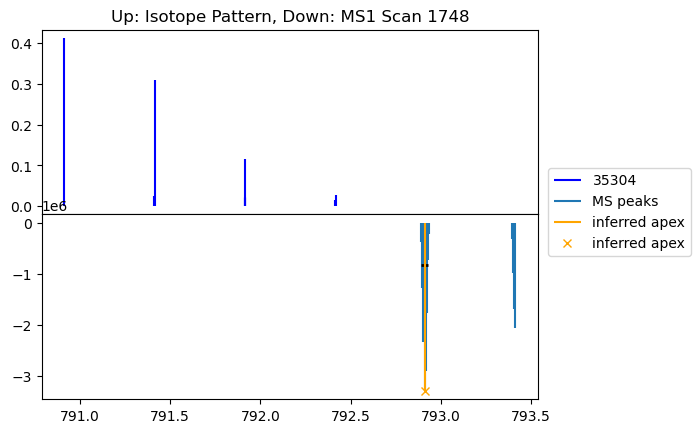

Peak results:
   apex_mzidx     apex_mz  start_mzidx    start_mz  end_mzidx      end_mz  \
0           6  509.773383            4  509.766475          9  509.783745   

   peak_width   peak_height  peak_intensity_sum  
0     0.01727  210815.90625        2.940859e+06  


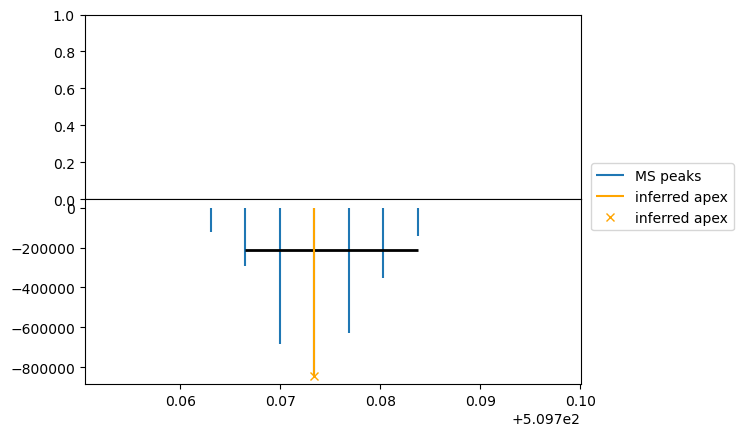

In [9]:
import result_analysis.result_analysis 
reload(result_analysis.result_analysis)
import result_analysis.result_analysis as RA
# to compare the range of isotope pattern belonging to one precursor
RA.PlotIsoPatternsAndScan(MS1Scans=MS1Scans, 
                             Maxquant_result=Maxquant_result_dict, 
                             scan_idx = 1748, 
                             precursor_id=[114498], 
                             log_intensity=False)
# to see peaks in a specific range
RA.PlotIsoPatternsAndScan(scan_idx=748, 
                             precursor_idx=None, 
                             mzrange = [509.75, 509.80], 
                             MS1Scans=MS1Scans, 
                             Maxquant_result=Maxquant_result_dict, 
                             log_intensity=False)

# ID and Qunat

## One Scan

2023-11-27 14:03:46,006 - optimization.inference - DEBUG - Start.
2023-11-27 14:03:46,042 - optimization.inference - DEBUG - Filter by RT.
2023-11-27 14:03:46,043 - optimization.dictionary - INFO - Number of candidates by RT 3273
2023-11-27 14:03:46,092 - optimization.dictionary - INFO - Number of candidates after isotope match 1438
2023-11-27 14:03:46,093 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 312
2023-11-27 14:03:46,143 - optimization.dictionary - DEBUG - [Double check] Number of candidates by RT and abundance filter 312
2023-11-27 14:03:46,265 - optimization.dictionary - INFO - Number of candidate pairs with correlation larger than 0.97: 205
2023-11-27 14:03:46,267 - optimization.dictionary - INFO - Number of candidated involved in high correlation: 180
2023-11-27 14:03:46,268 - optimization.inference - DEBUG - Construct dictionary
2023-11-27 14:03:46,269 - optimization.inference - DEBUG - obs mz (index) dimension: (865,)
2023-11-27 14

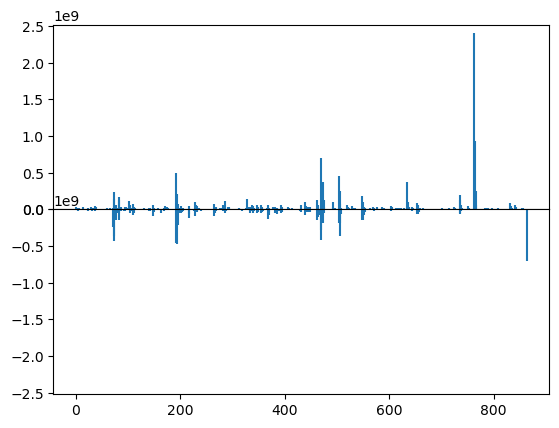

In [30]:
%autoreload 2
from result_analysis import result_analysis
from optimization.inference import process_one_scan, Quant
scan_idx =639
RT_tol = 1.0
RT_ref = 'mix'                            
# example: generate dictionary for candidate in one scan
OneScan = MS1Scans.iloc[scan_idx, :]
# Set left and right edge for scan search range
if RT_ref == 'exp':
    Maxquant_result_dict['RT_search_left'] = Maxquant_result_dict['Calibrated retention time start'] - RT_tol
    Maxquant_result_dict['RT_search_right'] = Maxquant_result_dict['Calibrated retention time finish'] + RT_tol
elif RT_ref == 'pred':
    Maxquant_result_dict['RT_search_left'] = Maxquant_result_dict['predicted_RT'] - RT_tol
    Maxquant_result_dict['RT_search_right'] = Maxquant_result_dict['predicted_RT'] + RT_tol
elif RT_ref == 'mix':
    Maxquant_result_dict['RT_search_left'] = Maxquant_result_dict['Retention time new'] - RT_tol
    Maxquant_result_dict['RT_search_right'] = Maxquant_result_dict['Retention time new'] + RT_tol
scan_result, scan_dict, Quant = process_one_scan(scan_idx=scan_idx,
                                AbundanceMissingThres=0.3, 
                                OneScan=OneScan,
                                loss = 'lasso',
                                alpha_criteria = 'min',
                                alphas=[0],
                                metric='RMSE',
                                opt_algo= 'threshold',
                                Maxquant_result=Maxquant_result_dict, 
                                preprocessing_method='raw',
                                max_iter=250,
                                corr_thres=0.97,
                                return_interim_results=True,
                                plot_alpha_trace=False,
                                plot_obs_and_infer=True)

In [31]:
a = pd.DataFrame(scan_result[scan_idx]['activation'])
a[a['precursor'] == 44321]

,precursor,activation
80,44321,2.972822e+06


2023-11-22 14:27:03,623 - result_analysis.result_analysis - DEBUG - infer m/z and intensities: Float64Index([688.798643127982, 689.2980074464168], dtype='float64'), [0. 0.]


Isotope Pattern: 14213 [688.800408   689.29892545 689.30208542 689.80060287 689.8025305
 689.80376284 690.30420792 690.30544025] [0.49150318 0.03054204 0.28409012 0.01765338 0.02627883 0.08055331
 0.01518923 0.01493435]


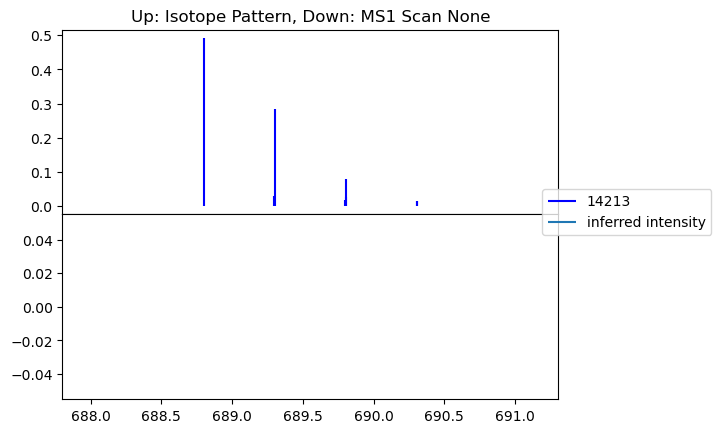

In [109]:
Quant.plot_iso_pattern_and_infer(Maxquant_result = Maxquant_result_dict,
                                     precursor_id = [44321],
                                     log_intensity=False)

In [57]:
dict = scan_dict.dict

<module 'optimization.dictionary' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/dictionary.py'>

2023-11-22 13:25:32,210 - optimization.dictionary - INFO - Number of candidates by RT 3272
2023-11-22 13:25:32,247 - optimization.dictionary - INFO - Number of candidates after isotope match 1192
2023-11-22 13:25:32,248 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 242
2023-11-22 13:25:32,278 - optimization.dictionary - DEBUG - [Double check] Number of candidates by RT and abundance filter 242


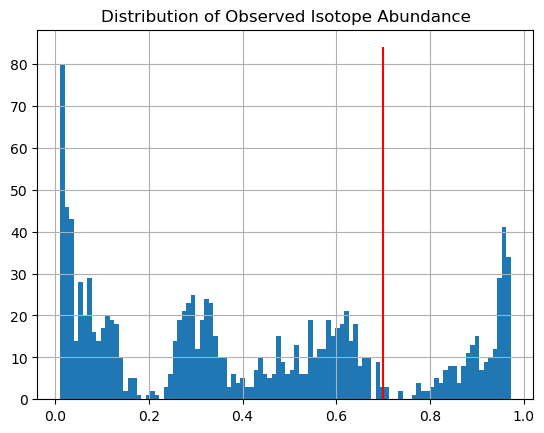

In [15]:
import optimization.dictionary
reload(optimization.dictionary)
from optimization.dictionary import Dict
CandidatePrecursorsByRT = Maxquant_result_dict.loc[
            (Maxquant_result_dict['RT_search_left'] <= OneScan['starttime']) & 
            (Maxquant_result_dict['RT_search_right'] >= OneScan['starttime'])]
ScanDict = Dict(CandidateByRT=CandidatePrecursorsByRT,
                OneScan=OneScan,
                AbundanceMissingThres=0.3)
ScanDict.plot_observe_iso_abundance()

2023-11-21 13:33:50,617 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


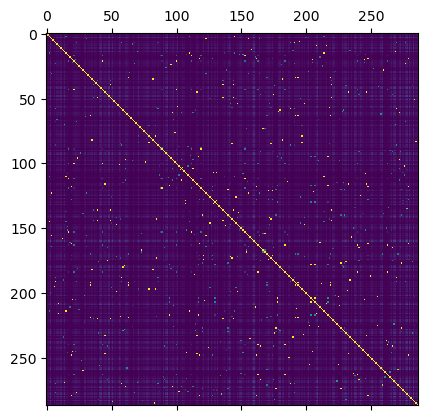

2023-11-21 13:33:51,211 - optimization.dictionary - INFO - Number of candidate pairs with correlation larger than 0.95: 141
2023-11-21 13:33:51,212 - optimization.dictionary - INFO - Number of candidated involved in high correlation: 161


In [16]:
%matplotlib inline
ScanDict.get_feature_corr(corr_thres=0.95, plot_hist=False)

<module 'result_analysis.result_analysis' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

Peak results:
     apex_mzidx     apex_mz  start_mzidx    start_mz  end_mzidx      end_mz  \
0             8  600.296767            5  600.283526         10  600.305595   
1            26  600.631228           23  600.617976         28  600.640063   
2            42  600.962982           40  600.954140         45  600.976246   
3            58  601.259327           56  601.250478         61  601.272600   
4            66  601.294723           63  601.281449         69  601.307997   
..          ...         ...          ...         ...        ...         ...   
288        4273  985.599337         4271  985.580766       4276  985.627194   
289        4291  986.602845         4289  986.584246       4294  986.630745   
290        4307  987.608364         4304  987.580423       4309  987.626993   
291        4322  992.507007         4319  992.478857       4324  992.525774   
292        4336  993.502385         4334  993.483590       4339  993.531192   

     peak_width   peak_height  peak_i

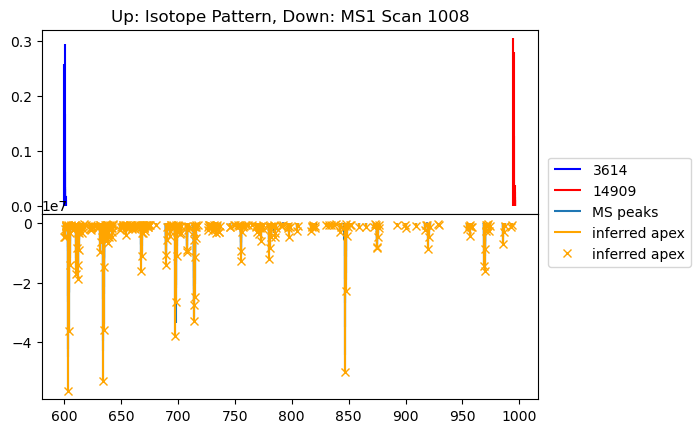

In [17]:
import result_analysis.result_analysis 
reload(result_analysis.result_analysis)
import result_analysis.result_analysis as RA
# to see peaks in a specific range
RA.PlotIsoPatternsAndScan(scan_idx=1008, 
                            precursor_idx=[3614,14909], 
                            mzrange = None, 
                            MS1Scans=MS1Scans, 
                            Maxquant_result=Maxquant_result_dict, 
                            log_intensity=False)

### Explore Isotope Pattern between Sequence

In [18]:
import IsoSpecPy as iso
pair = [4129, 6698]
Maxquant_result_dict.loc[pair, ['Modified sequence', 'Charge','Retention time', 'Intensity', 'm/z']]
iso.ParseFASTA(Maxquant_result_dict.loc[pair[0], 'Modified sequence'])
iso.ParseFASTA(Maxquant_result_dict.loc[pair[1], 'Modified sequence'])

,Modified sequence,Charge,Retention time,Intensity,m/z
4129,_ANGANTVIGPLNWDEK_,2,21.400,14850000.0,849.925926
6698,_CVDTSMGLTPLEGLVMGTR_,2,29.274,124510000.0,1018.994310


OrderedDict([('C', 74), ('H', 113), ('N', 21), ('O', 24), ('S', 0)])

OrderedDict([('C', 82), ('H', 140), ('N', 22), ('O', 27), ('S', 3)])

In [20]:
from optimization.dictionary import CalcModpeptIsopattern
CalcModpeptIsopattern(modpept='_EKVEGTIDK_', charge=2, ab_thres=0.001)

(array([509.77494504, 510.27346248, 510.27662245, 510.27705361,
        510.27808341, 510.7751399 , 510.77706753, 510.77829987,
        510.77873102, 510.77976083, 511.27681732, 511.27874495,
        511.27997729, 511.78042237, 511.78165471]),
 array([0.57300948, 0.02303972, 0.26871023, 0.00372042, 0.00510591,
        0.01080438, 0.02003166, 0.06153999, 0.00174467, 0.00239439,
        0.00247442, 0.00939376, 0.00917221, 0.00215136, 0.00100029]))

## Batch Scan Processing

In [85]:
import optimization.inference
reload(optimization.inference)
from multiprocessing import cpu_count
from optimization.inference import process_scans_parallel, process_one_scan
RT_ref == 'mix'
RT_tol = 1.0
# Set left and right edge for scan search range
if RT_ref == 'exp':
    Maxquant_result_dict['RT_search_left'] = Maxquant_result_dict['Calibrated retention time start'] - RT_tol
    Maxquant_result_dict['RT_search_right'] = Maxquant_result_dict['Calibrated retention time finish'] + RT_tol
elif RT_ref == 'pred':
    Maxquant_result_dict['RT_search_left'] = Maxquant_result_dict['predicted_RT'] - RT_tol
    Maxquant_result_dict['RT_search_right'] = Maxquant_result_dict['predicted_RT'] + RT_tol
elif RT_ref == 'mix':
    Maxquant_result_dict['RT_search_left'] = Maxquant_result_dict['Retention time new'] - RT_tol
    Maxquant_result_dict['RT_search_right'] = Maxquant_result_dict['Retention time new'] + RT_tol
result_dict = process_scans_parallel(n_jobs=cpu_count(),
                                     alphas=[0, 100, 1000, 10000, 100000, 1000000],
                                     AbundanceMissingThres=1.0,
                                        MS1Scans=MS1Scans.iloc[638:646, :], # for small scale testing: MS1Scans.iloc[1000:1050, :]
                                        Maxquant_result=Maxquant_result_dict,
                                        preprocessing_method='raw',
                                        loss='lasso',
                                        opt_algo='threshold')


<module 'optimization.inference' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/inference.py'>

True

2023-11-22 14:08:08,394 - optimization.dictionary - INFO - Number of candidates by RT 3274
2023-11-22 14:08:08,436 - optimization.dictionary - INFO - Number of candidates after isotope match 1484
2023-11-22 14:08:08,437 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 1484
2023-11-22 14:08:10,352 - optimization.dictionary - INFO - Number of candidates by RT 3273
2023-11-22 14:08:10,407 - optimization.dictionary - INFO - Number of candidates after isotope match 1438
2023-11-22 14:08:10,408 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 1438
2023-11-22 14:08:11,990 - optimization.dictionary - INFO - Number of candidate pairs with correlation larger than 0.95: 106211
2023-11-22 14:08:11,995 - optimization.dictionary - INFO - Number of candidated involved in high correlation: 1116
2023-11-22 14:08:12,014 - optimization.inference - INFO - Reached convergence criteria at alpha = 100
2023-11-22 14:08:12,015 - optimi

In [87]:
# merge results
n_ms1scans = MS1Scans.shape[0]
activation = pd.DataFrame(index=Maxquant_result_dict['id'], columns=range(n_ms1scans))
scan_record_list = []
#scan_alignments = {}
for scan_idx, result_dict_scan in result_dict.items():
    if result_dict_scan['activation'] is not None:
        activation.loc[result_dict_scan['activation']['precursor'], scan_idx] = \
                    result_dict_scan['activation']['activation']
    scan_record_list.append(result_dict_scan['scans_record'])
    #scan_alignments[scan_idx] = result_dict_scan['alignment']
scan_record = pd.DataFrame(scan_record_list, columns= ['Scan', 
                                                        'Time', 
                                                        'CandidatePrecursorByRT', 
                                                        'FilteredPrecursor',
                                                        'NumberHighlyCorrDictCandidate',
                                                        'BestAlpha',
                                                        'Cosine Dist',  
                                                        'IntensityExplained'])

In [88]:
a = activation.loc[:, 638:646]

In [141]:
import optimization.inference
reload(optimization.inference)
from multiprocessing import cpu_count
from optimization.inference import process_scans_parallel
RT_ref == 'exp'
RT_tol = 1.0
# Set left and right edge for scan search range
if RT_ref == 'exp':
    Maxquant_result_dict['RT_search_left'] = Maxquant_result_dict['Calibrated retention time start'] - RT_tol
    Maxquant_result_dict['RT_search_right'] = Maxquant_result_dict['Calibrated retention time finish'] + RT_tol
elif RT_ref == 'pred':
    Maxquant_result_dict['RT_search_left'] = Maxquant_result_dict['predicted_RT'] - RT_tol
    Maxquant_result_dict['RT_search_right'] = Maxquant_result_dict['predicted_RT'] + RT_tol
result_dict = process_scans_parallel(n_jobs=cpu_count(),
                                     MS1Scans=MS1Scans.iloc[1000:1010, :], # for small scale testing: MS1Scans.iloc[1000:1050, :]
                                     Maxquant_result=Maxquant_result_dict,
                                        preprocessing_method='raw',
                                        AbundanceMissingThres=0.5)


<module 'optimization.inference' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/inference.py'>

False

2023-11-15 13:05:51,097 - optimization.dictionary - INFO - Number of candidates by RT 4638
2023-11-15 13:05:51,157 - optimization.dictionary - INFO - Number of candidates after isotope match 1674
2023-11-15 13:05:51,158 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 636
2023-11-15 13:05:51,779 - optimization.dictionary - INFO - Number of candidate pairs with correlation larger than 0.95: 362
2023-11-15 13:05:51,781 - optimization.dictionary - INFO - Number of candidated involved in high correlation: 388
/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2089985829642426e+17, tolerance: 415896198849370.4
  model = cd_fast.enet_coordinate_descent_gram(
/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: Co

In [138]:
# merge results
n_precursors = Maxquant_result_dict.shape[0]
n_ms1scans = MS1Scans.shape[0]
activation = pd.DataFrame(index=Maxquant_result_dict['id'], columns=range(len(result_dict)))
scan_record_list = []
#scan_alignments = {}
for scan_idx, result_dict_scan in result_dict.items():
    if result_dict_scan['activation'] is not None:
        activation.loc[result_dict_scan['activation']['precursor'], scan_idx] = result_dict_scan['activation']['activation']
    scan_record_list.append(result_dict_scan['scans_record'])
    #scan_alignments[scan_idx] = result_dict_scan['alignment']
scan_record = pd.DataFrame(scan_record_list, columns= ['Scan', 
                                                        'Time', 
                                                        'CandidatePrecursorByRT', 
                                                        'FilteredPrecursor',
                                                        'NumberHighlyCorrDictCandidate',
                                                        'BestAlpha',
                                                        'Cosine Dist',  
                                                        'IntensityExplained'])

In [60]:
n_precursors = Maxquant_result_dict.shape[0]
n_ms1scans = MS1Scans.shape[0]
activation = np.zeros((n_precursors, n_ms1scans))
scan_record_list = []
scan_alignments = {}
for scan_idx, result_dict_scan in result_dict.items():
    if result_dict_scan['activation'] is not None:
        activation[result_dict_scan['activation']['precursor'], scan_idx] = result_dict_scan['activation']['activation']
    scan_record_list.append(result_dict_scan['scans_record'])
    scan_alignments[scan_idx] = result_dict_scan['alignment']
scan_summary = pd.DataFrame(scan_record_list, columns= ['Scan', 
                                                        'Time', 
                                                        'CandidatePrecursorByRT', 
                                                        'FilteredPrecursor',
                                                        'NumberHighlyCorrDictCandidate',
                                                        'BestAlpha',
                                                        'Cosine Dist',  
                                                        'IntensityExplained'])

<module 'result_analysis.result_analysis' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

-------------- Intensity -----------------
Non zero intensity in Intensity = 16871
--------------Empty Scans-----------------
-------------- Time_EmptyScans -----------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Time, dtype: float64
-------------- n_CandidateByRT_EmptyScans -----------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: n_CandidateByRT, dtype: float64
-------------- n_filteredCandidate_EmptyScans -----------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: n_filteredCandidate, dtype: float64
-------------- preservedRatio_IE_filter_EmptyScans -----------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: preservedRatio_IE_filter, dtype: float64
--------------Non Empty Scans-----------------
Column  Loss do

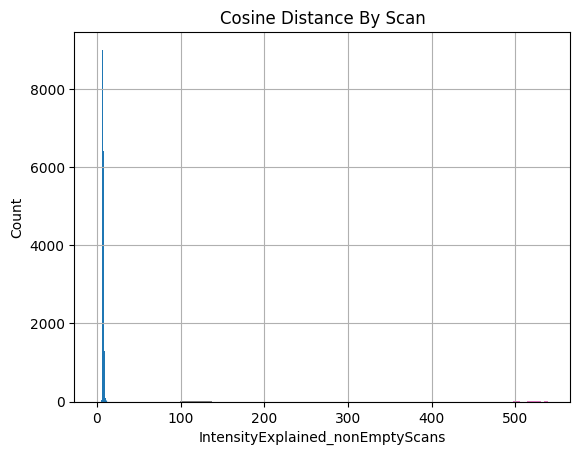

In [26]:
import result_analysis.result_analysis
reload(result_analysis.result_analysis)
from result_analysis.result_analysis import GenerateResultReport
scan_record_processed = GenerateResultReport(scan_record=scan_summary,
                                             intensity_cols=[Maxquant_result_dict['Intensity']])

In [42]:
import optimization.inference
reload(optimization.inference)
from optimization.inference import process_scans

result_dict = process_scans(MS1Scans=MS1Scans.iloc[600:610, :],
                            Maxquant_result=Maxquant_result_dict)

<module 'optimization.inference' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/inference.py'>

2023-11-06 13:53:33,942 - optimization.inference - DEBUG - Current alpha = 1e-05
2023-11-06 13:53:33,945 - optimization.inference - DEBUG - Alpha list [0, 1e-05]
2023-11-06 13:53:33,946 - optimization.inference - DEBUG - Alpha = 1e-05, tol = 0.0005284012636698199
2023-11-06 13:53:33,947 - optimization.inference - DEBUG - Current alpha = 0.0001
2023-11-06 13:53:33,950 - optimization.inference - DEBUG - Alpha list [0, 1e-05, 0.0001]
2023-11-06 13:53:33,951 - optimization.inference - DEBUG - Alpha = 0.0001, tol = 0.0
2023-11-06 13:53:33,952 - optimization.inference - DEBUG - Current alpha = 0.001
2023-11-06 13:53:33,954 - optimization.inference - DEBUG - Alpha list [0, 1e-05, 0.0001, 0.001]
2023-11-06 13:53:33,955 - optimization.inference - DEBUG - Alpha = 0.001, tol = 0.0
2023-11-06 13:53:33,957 - optimization.inference - DEBUG - Current alpha = 0.01
2023-11-06 13:53:33,959 - optimization.inference - DEBUG - Alpha list [0, 1e-05, 0.0001, 0.001, 0.01]
2023-11-06 13:53:33,960 - optimizatio

In [ ]:
n_precursors = Maxquant_result_dict.shape[0]
n_ms1scans = MS1Scans.shape[0]
activation = np.zeros((n_precursors, n_ms1scans))
loss = []
empty_scans = []
ScanProcessRecords = {}
for scan_idx, OneScan in MS1Scans.iterrows(): # scan by scan activation
    CandidatePrecursorsByRT = Maxquant_result_dict.loc[(Maxquant_result_dict['Calibrated retention time start']-RT_tol <= OneScan['starttime']) & \
        (Maxquant_result_dict['Calibrated retention time finish']+RT_tol>= OneScan['starttime'])]
    if CandidatePrecursorsByRT.shape[0] > 0:
        CandidateDict, CandidatePrecursorsByRT, alignment, IsotopeNotObs, y_true, peak_results = ConstructDict(CandidatePrecursorsByRT, OneScan, method = 'peakRange')
        filteredPrecursorIdx = np.array(CandidateDict.columns[1:], dtype=int)
        if CandidateDict.shape[1] > 1:
            activationByScan, lossByScan, scoreByScan, pred, explainedInt, explainedPeaks = CalcPrecursorQuant(CandidateDict, y_true, filteredPrecursorIdx=filteredPrecursorIdx, alpha=alpha)
            activation[filteredPrecursorIdx, scan_idx] = activationByScan
            loss.append(lossByScan)
            score.append(scoreByScan)
            RA.PlotTrueAndPredict(x = CandidateDict.index, prediction=pred, true=y_true['intensity'], log = True)
        else:
            lossByScan = None
            print('Scan number, start time ', scan_idx, OneScan['starttime'], 'does not have valid candidate.')
            empty_scans.append((scan_idx, OneScan['starttime']))
        ScanProcessRecords[scan_idx] = {'CandidatePrecursorIdx':CandidatePrecursorsByRT.index,
                                'FilteredCandidatePrecursor':filteredPrecursorIdx,
                                'Residue':lossByScan,
                                'alignment':alignment
                                }
    else:
        print('Scan number, start time ', scan_idx, OneScan['starttime'], 'does not have valid candidate.')

In [ ]:
empty_scans = pd.DataFrame(empty_scans, columns=['Scan', 'Time'])

In [ ]:
tmp = activation[:, 2400:2500]
a=tmp.sum(axis = 1)
np.array(a>0).sum()

In [ ]:
activationSumByScan = activation.sum(axis = 0)
np.array(activationSumByScan>0).sum()

In [ ]:
activationSumByPrecursor = activation.sum(axis = 1)
np.array(activationSumByPrecursor>0).sum()

In [ ]:
Intensity_comparison = pd.DataFrame({'MQ_int':Maxquant_result_dict['Intensity'], 'Inf_int':activationSumByPrecursor})
Intensity_comparison = Intensity_comparison[Intensity_comparison['Inf_int']>0].dropna()

In [ ]:
np.save(output_file+'_activationByScanFromLasso.npy', activation)


In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x = range(1650,1700), y = activation[17754, 1650:1700])